# <center>CITS5508 Lab sheet 2: Classification on Forest type mapping</center>

**Name: Manh Duy Thai Nguyen**<br>
**Student number: 21986407**<br>
**Date created:** March 12th 2020<br>
**Last modified:** March 12th 2020<br>

The data set contains training and testing data from a remote sensing study which mapped different forest types based on their spectral characteristics at visible-to-near infrared wavelengths, using ASTER satellite imagery. The output (forest type map) can be used to identify and/or quantify the ecosystem services (e.g. carbon storage, erosion protection) provided by the forest.


# 0. Environment Setup

Importing packages and downloading the dataset from my personal Github.

In [2]:
# Import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import sklearn as sklearn
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.multiclass import OneVsOneClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# Download dataset
if not os.path.exists("/content/cits5508datasets"):
  !git clone https://github.com/thaingu/cits5508datasets.git

Cloning into 'cits5508datasets'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 11 (delta 0), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


# 1. Data Loading & Visualisation

In this section the csv files are read into pandas dataframes. The first couple of rows are displayed showing all the columns in the data. The data is then plotted on a scatterplot after extracting the classes.

In [4]:
# Set up global variables for the data
testingPath = "/content/cits5508datasets/lab2/testing.csv"
trainingPath = "/content/cits5508datasets/lab2/training.csv"


def load_data(training_csv,test_csv):
    training_data = pd.read_csv(training_csv)
    test_data =pd.read_csv(test_csv)
    return training_data,test_data

#Declare file names
training_file = "training.csv"
test_file = "test.csv"
trainingTable,testingTable = load_data(training_file,test_file)


In [5]:
# Table for the testing data
testingTable.head()

,class,b1,b2,b3,b4,b5,b6,b7,b8,b9,...,pred_minus_obs_H_b9,pred_minus_obs_S_b1,pred_minus_obs_S_b2,pred_minus_obs_S_b3,pred_minus_obs_S_b4,pred_minus_obs_S_b5,pred_minus_obs_S_b6,pred_minus_obs_S_b7,pred_minus_obs_S_b8,pred_minus_obs_S_b9
0,d,39,36,57,91,59,101,93,27,60,...,-2.36,-18.41,-1.88,-6.43,-21.03,-1.60,-6.18,-22.50,-5.20,-7.86
1,h,84,30,57,112,51,98,92,26,62,...,-2.26,-16.27,-1.95,-6.25,-18.79,-1.99,-6.18,-23.41,-8.87,-10.83
2,s,53,25,49,99,51,93,84,26,58,...,-1.46,-15.92,-1.79,-4.64,-17.73,-0.48,-4.69,-19.97,-4.10,-7.07
3,s,59,26,49,103,47,92,82,25,56,...,2.68,-13.77,-2.53,-6.34,-22.03,-2.34,-6.60,-27.10,-7.99,-10.81
4,d,57,49,66,103,64,106,114,28,59,...,-2.94,-21.74,-1.64,-4.62,-23.74,-0.85,-5.50,-22.83,-2.74,-5.84


In [6]:
# Table for the training data
trainingTable.head()

,class,b1,b2,b3,b4,b5,b6,b7,b8,b9,...,pred_minus_obs_H_b9,pred_minus_obs_S_b1,pred_minus_obs_S_b2,pred_minus_obs_S_b3,pred_minus_obs_S_b4,pred_minus_obs_S_b5,pred_minus_obs_S_b6,pred_minus_obs_S_b7,pred_minus_obs_S_b8,pred_minus_obs_S_b9
0,d,67,51,68,115,69,111,136,31,67,...,-9.17,-18.27,-1.80,-6.32,-20.88,-1.63,-6.13,-22.56,-5.53,-8.11
1,s,67,28,51,99,50,97,82,26,59,...,-2.25,-20.13,-2.11,-6.35,-21.94,-1.22,-6.13,-22.20,-3.41,-6.57
2,s,63,26,50,95,49,91,81,26,57,...,-0.44,-17.64,-1.81,-4.70,-19.39,-0.65,-5.01,-20.89,-3.96,-6.85
3,d,63,42,63,97,66,108,111,28,59,...,-2.34,-20.20,-1.89,-5.47,-21.65,-0.99,-5.71,-22.19,-3.41,-6.52
4,s,46,27,50,83,51,90,76,26,56,...,1.25,-18.62,-2.17,-7.11,-21.12,-1.56,-6.35,-22.19,-4.45,-7.32


Graphing the data set by class using b1-b9 against the predicted minus obs metrics. With each class showing up as different colors in the scatterplot.

[Text(0, 0.5, 'pred minus obs S'), Text(0.5, 0, 'b (spectral wavelength)')]

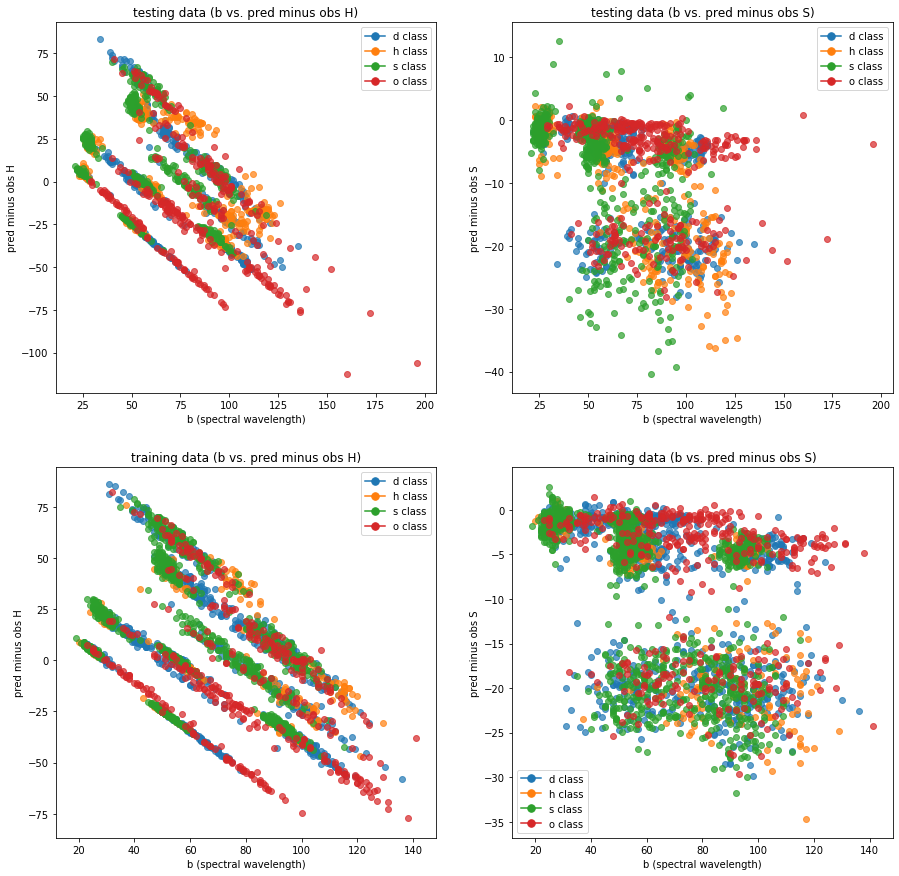

In [7]:
# Set up the legends for the graphs
d_line = mlines.Line2D([], [], color='#1f77b4', marker='.', markersize=15, label='d class')
h_line = mlines.Line2D([], [], color='#ff7f0e', marker='.', markersize=15, label='h class')
s_line = mlines.Line2D([], [], color='#2ca02c', marker='.', markersize=15, label='s class')
o_line = mlines.Line2D([], [], color='#d62728', marker='.', markersize=15, label='o class')

# Extract out classes from testing dataset
test_d = testingTable[testingTable['class'] == "d "]
test_h = testingTable[testingTable['class'] == "h "]
test_s = testingTable[testingTable['class'] == "s "]
test_o = testingTable[testingTable['class'] == "o "]

# Extract out classes from training dataset
train_d = trainingTable[trainingTable['class'] == "d "]
train_h = trainingTable[trainingTable['class'] == "h "]
train_s = trainingTable[trainingTable['class'] == "s "]
train_o = trainingTable[trainingTable['class'] == "o "]

# Add subplots for the data
f = plt.figure(figsize=(15,15))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)

# Graph scatterplots of each graph with information provided by the titles and labels
# Data from testing dataset, b vs pred minus obs H
ax1.scatter(test_d[test_d.columns[1:10]], test_d[test_d.columns[10:19]], color="#1f77b4", alpha=0.7)
ax1.scatter(test_h[test_h.columns[1:10]], test_h[test_h.columns[10:19]], color="#ff7f0e", alpha=0.7)
ax1.scatter(test_s[test_s.columns[1:10]], test_s[test_s.columns[10:19]], color="#2ca02c", alpha=0.7)
ax1.scatter(test_o[test_o.columns[1:10]], test_o[test_o.columns[10:19]], color="#d62728", alpha=0.7)
ax1.legend(handles=[d_line, h_line, s_line, o_line])
ax1.set_title('testing data (b vs. pred minus obs H)')
ax1.set(xlabel="b (spectral wavelength)",ylabel="pred minus obs H")

# Data from testing dataset, b vs pred minus obs S
ax2.scatter(test_d[test_d.columns[1:10]], test_d[test_d.columns[19:28]], color="#1f77b4", alpha=0.7)
ax2.scatter(test_h[test_h.columns[1:10]], test_h[test_h.columns[19:28]], color="#ff7f0e", alpha=0.7)
ax2.scatter(test_s[test_s.columns[1:10]], test_s[test_s.columns[19:28]], color="#2ca02c", alpha=0.7)
ax2.scatter(test_o[test_o.columns[1:10]], test_o[test_o.columns[19:28]], color="#d62728", alpha=0.7)
ax2.legend(handles=[d_line, h_line, s_line, o_line])
ax2.set_title('testing data (b vs. pred minus obs S)')
ax2.set(xlabel="b (spectral wavelength)",ylabel="pred minus obs S")

# Data from training dataset, b vs pred minus obs H
ax3.scatter(train_d[train_d.columns[1:10]], train_d[train_d.columns[10:19]], color="#1f77b4", alpha=0.7)
ax3.scatter(train_h[train_h.columns[1:10]], train_h[train_h.columns[10:19]], color="#ff7f0e", alpha=0.7)
ax3.scatter(train_s[train_s.columns[1:10]], train_s[train_s.columns[10:19]], color="#2ca02c", alpha=0.7)
ax3.scatter(train_o[train_o.columns[1:10]], train_o[train_o.columns[10:19]], color="#d62728", alpha=0.7)
ax3.legend(handles=[d_line, h_line, s_line, o_line])
ax3.set_title('training data (b vs. pred minus obs H)')
ax3.set(xlabel="b (spectral wavelength)",ylabel="pred minus obs H")

# Data from training dataset, b vs pred minus obs S
ax4.scatter(train_d[train_d.columns[1:10]], train_d[train_d.columns[19:28]], color="#1f77b4", alpha=0.7)
ax4.scatter(train_h[train_h.columns[1:10]], train_h[train_h.columns[19:28]], color="#ff7f0e", alpha=0.7)
ax4.scatter(train_s[train_s.columns[1:10]], train_s[train_s.columns[19:28]], color="#2ca02c", alpha=0.7)
ax4.scatter(train_o[train_o.columns[1:10]], train_o[train_o.columns[19:28]], color="#d62728", alpha=0.7)
ax4.legend(handles=[d_line, h_line, s_line, o_line])
ax4.set_title('training data (b vs. pred minus obs S)')
ax4.set(xlabel="b (spectral wavelength)",ylabel="pred minus obs S")

### Analysis

When the features are graphed against the predicted minus obs H, various parallel lines are distinctly present. This is evident in both the testing and training datasets. The four classes are all distributed across the lines. This shows there is a correlation in the data which is promising for a machine learning task. 

For the graphs on the right, where it is against predicted minus obs S, there seems to be a different relationship, although there are no lines formed, there is two clusters of data points which seem to have evenly distributed classes amongst themselves.

Both these graphs shows strong evidence of a relationship existing in the data and across all classes. Furthermore the training and testing data shows the same relationship between each other which is good for training and validation later on.

# 2. Data Cleaning, Checking & Normalisation

Getting the data columns b1-b9 from the training and testing data.


In [8]:
# Getting the data columns b1-b9 from the training data.
nineTraining = trainingTable[trainingTable.columns[0:10]]
nineTraining.describe()

,b1,b2,b3,b4,b5,b6,b7,b8,b9
count,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000
mean,58.021538,38.381538,61.467692,96.175385,58.098462,99.196923,85.864615,27.375385,58.880000
std,11.705076,14.589516,15.003385,11.120136,10.654920,9.438789,16.642765,7.445316,8.884777
min,31.000000,23.000000,47.000000,69.000000,43.000000,83.000000,42.000000,19.000000,45.000000
25%,50.000000,28.000000,52.000000,89.000000,51.000000,93.000000,73.000000,24.000000,54.000000
50%,57.000000,32.000000,55.000000,95.000000,54.000000,96.000000,85.000000,25.000000,57.000000
75%,65.000000,43.000000,65.000000,103.000000,63.000000,103.000000,98.000000,27.000000,60.000000
max,107.000000,91.000000,124.000000,141.000000,100.000000,138.000000,136.000000,84.000000,114.000000


In [9]:
# Getting the data columns b1-b9 from the testing data.
nineTesting = testingTable[testingTable.columns[0:10]]
nineTesting.describe()

,b1,b2,b3,b4,b5,b6,b7,b8,b9
count,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000
mean,62.949495,41.020202,63.676768,101.409091,58.732323,100.651515,90.601010,28.691919,61.116162
std,12.779563,17.832543,17.314545,14.804627,12.392648,11.190314,15.588861,8.977752,9.787158
min,34.000000,25.000000,47.000000,54.000000,44.000000,84.000000,54.000000,21.000000,50.000000
25%,54.000000,28.000000,52.000000,92.250000,49.000000,92.000000,80.000000,24.000000,55.000000
50%,60.000000,31.500000,57.000000,99.500000,55.000000,98.000000,91.000000,25.000000,58.000000
75%,70.750000,50.750000,69.000000,111.750000,65.000000,107.000000,101.000000,27.000000,63.000000
max,105.000000,160.000000,196.000000,172.000000,98.000000,136.000000,139.000000,82.000000,109.000000


This is the pipeline function for preprocessing the data. It extracts the correct columns out, grab the classes and balance the classes if required, then finally normalises with a min max scaler.

In [10]:
# Function for min max normalisation for preprocessing the data
def minMaxPreProcess(dataTable):
    scaler = preprocessing.MinMaxScaler()

    for col in dataTable.columns:
        if 'class' not in col:
            dataTable[col] = scaler.fit_transform(dataTable[col].values.reshape(-1, 1))

# Pipeline for data preprocessing
def pipelineProcess(dataTable):
  # Grab just the columns we want
  extractedData = dataTable.loc[:,['class','b1','b2','b3','b4','b5','b6','b7','b8','b9']]
  
  # Split into the four classes, remember there is a whitespace after the class name
  class_d = extractedData[extractedData['class'] == "d "]
  class_h = extractedData[extractedData['class'] == "h "]
  class_s = extractedData[extractedData['class'] == "s "]
  class_o = extractedData[extractedData['class'] == "o "]
  
  # Get the count of the classes in a list in the shape of [d, h, s, o]
  classData = [class_d, class_h, class_s, class_o]
  classCount = [class_d.shape[0],class_h.shape[0],class_s.shape[0],class_o.shape[0]]
  
  # Print out the counts
  print("In this dataset, the instances for class d is", classCount[0],", class h is", classCount[1], ", class s is", classCount[2], "and class o is", classCount[3])
  
  # Programatically check if dataset is balanced by checking if all elements in array are equal
  if not classCount.count(classCount[0]) == len(classCount):
    print("Dataset is imbalanced, performing up-sampling on minority classes now.")
    maxCount = max(classCount)
    maxIndexes = [i for i, j in enumerate(classCount) if j == maxCount]
    balancedData = list(map(lambda x: resample(classData[x[0]], replace=True, n_samples=maxCount, random_state=69) if x[1] != maxCount else classData[x[0]], enumerate(classCount)))
    balCounted = [data.shape[0] for data in balancedData]
    print("Data is now balanced with the count of classes being:", balCounted)
    combinedData = pd.concat(balancedData)
  else:
    print("Dataset is balanced, proceeding to normalisation.")
    combinedData = pd.concat(classData)
  
  # Normalise the data with min max scaler
  minMaxPreProcess(combinedData)  
  return combinedData, maxCount

In [11]:
# Run the pipeline function both the datasets
processedTraining, trainCount = pipelineProcess(trainingTable)
processedTraining.describe()
processedTesting, testCount = pipelineProcess(testingTable)
processedTesting.describe()

In this dataset, the instances for class d is 105 , class h is 38 , class s is 136 and class o is 46
Dataset is imbalanced, performing up-sampling on minority classes now.
Data is now balanced with the count of classes being: [136, 136, 136, 136]
In this dataset, the instances for class d is 54 , class h is 48 , class s is 59 and class o is 37
Dataset is imbalanced, performing up-sampling on minority classes now.
Data is now balanced with the count of classes being: [59, 59, 59, 59]


,b1,b2,b3,b4,b5,b6,b7,b8,b9
count,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000
mean,0.405765,0.132078,0.124104,0.438030,0.293628,0.348110,0.392903,0.235956,0.257001
std,0.177026,0.140367,0.124203,0.154984,0.239660,0.226577,0.188418,0.239069,0.200483
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.281690,0.022222,0.040268,0.329545,0.092593,0.173077,0.271875,0.085714,0.108696
50%,0.380282,0.066667,0.073826,0.420455,0.240741,0.288462,0.400000,0.114286,0.173913
75%,0.521127,0.214815,0.174497,0.556818,0.462963,0.480769,0.515625,0.257143,0.326087
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Given the count; the training dataset it is definately unbalanced. Classes d and s have far more data than classes h and o. The testing data however is fairly balanced except for class o.

In [12]:
def generateLabels(labelCount):
  classD = [0] * labelCount
  classH = [1] * labelCount
  classS = [2] * labelCount
  classO = [3] * labelCount
  classLabels = classD + classH + classS + classO
  return classLabels

trainLabels = generateLabels(trainCount)
testLabels = generateLabels(testCount)
X = processedTraining[processedTraining.columns[1:10]]
y = processedTraining['class'].tolist()
mlSVC = SVC(random_state=0, kernel='poly', C=1).fit(X, y)
print(mlSVC)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)


/Users/Joey/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [13]:
testX = processedTesting[processedTesting.columns[1:10]]
testY = processedTesting['class'].tolist()
mlSVC.score(testX,testY)


0.3728813559322034

In [14]:
param_grid = [
    {'kernels' : ['linear', 'rbf', 'poly'],
    'gammas' : [0.1, 1, 10, 100],
    'C' : [1]
    }
]

parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1]}

svm_clf = SVC()
scorer = sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average = 'micro')

grid_search_svm = GridSearchCV(svm_clf, 
                               parameters, 
                               scoring = scorer,
                               return_train_score = True)

#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

grid_search_svm.fit(X, y)


/Users/Joey/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/Joey/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/Joey/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/Joey/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/base.py:193: F

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1], 'kernel': ('linear', 'rbf', 'poly')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(f1_score, average=micro), verbose=0)

In [15]:
grid_search_svm.cv_results_

{'mean_fit_time': array([0.00637492, 0.00623775, 0.00569463]),
 'std_fit_time': array([0.00157387, 0.00064322, 0.00020092]),
 'mean_score_time': array([0.00458074, 0.00328461, 0.0027686 ]),
 'std_score_time': array([5.75119877e-04, 1.85662242e-04, 9.46675554e-05]),
 'param_C': masked_array(data=[1, 1, 1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['linear', 'rbf', 'poly'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1, 'kernel': 'linear'},
  {'C': 1, 'kernel': 'rbf'},
  {'C': 1, 'kernel': 'poly'}],
 'split0_test_score': array([0.85326087, 0.80978261, 0.41847826]),
 'split1_test_score': array([0.87777778, 0.82222222, 0.42777778]),
 'split2_test_score': array([0.84444444, 0.8       , 0.38888889]),
 'mean_test_score': array([0.85845588, 0.81066176, 0.41176471]),
 'std_test_score': array([0.01405765, 0.0090606 , 0.01653   ]),
 'rank_test

In [16]:
svm_clf.get_params().keys()

dict_keys(['C', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

## 3. Cells in Jupyter Notebook

There are two main types of cells: *Markdown* and *Code*. A *Markdown* cell is for you to put in formatted comments between *Code* cells to help explain to the reader what is going on in your code. You can double-click on a *Markdown* cell to edit its contents. You can even have complex equations put into a *Markdown* cell, like the example shown below:

$\text{MSE}(\theta) = \frac{1}{m} \sum_{i=1}^m 
                      (h_\theta(\mathbf{x}^{(i)}) - y^{(i)})^2$
                      
Rather than an equation on its own, mathematics symbols can appear in the same paragraph of the text, like here: The regularization coefficient $\alpha$ used in the experiment below is set to 0.5.

## 4. Navigation in Jupyter notebook

You can run the entire notebook, all the cells above the current cell, or all the cells below the current cell, etc. 

You can select a number of cells to delete, or to move them up/down. You can split the current cell by clicking your cursor at the point you want the split to take place. You can also merge the cell with the cell above or below. You can also insert a new cell below or after the current cell to experiment or test things. These cells should be removed afterwards.

You can clear all the output cells as well. This is a useful thing to do if you want to email your Jupyter notebook file to someone but it is too large to attach in your email because of many graphical outputs. Of course, this will require the recipient to run your Juyter notebook file in order to regenerate all the outputs.

**In your assignment submission, it may be necessary to clear all of your output cells so that your file is small enough to submit.**

Every now and then, you should do a *Save and Checckpoint* to make sure that all your changes are saved.

If you encounter the *dead kernel* problem, save your work and quit. Restarting Jupyter Notebook usually helps solve this problem.

## 5. More heading...

In [0]:
# more code here